# 05 - Final Model Evaluation

This notebook evaluates:
1. Raw machine learning model performance
2. Final business-rule-adjusted decisions
3. Impact of business rules on approvals and risk

The goal is to demonstrate how ML + business logic
together form a production-ready decision system.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# 1. LOAD DATA AND MODELS
test_results = pd.read_csv("../results/loan_decisions_with_rules.csv")
lr_model = joblib.load("../results/logistic_model.pkl")
rf_model = joblib.load("../results/random_forest_model.pkl")

In [4]:
# 2. DEFINE EVALUATION VARIABLES
y_true = test_results['approval']
y_model = test_results['ML_Prediction']
y_final = test_results['Final_Decision'].map({'Approved': 1, 'Rejected': 0})

In [5]:
# Check if the column is already numeric or needs mapping
if test_results['Final_Decision'].dtype == object:
    # It's strings, so clean and map it
    y_final = test_results['Final_Decision'].str.strip().map({'Approved': 1, 'Rejected': 0})
else:
    # It's already numeric (0/1), just copy it
    y_final = test_results['Final_Decision']

# Final safety check for missing values
y_final = y_final.fillna(0).astype(int)

print("\n=== PERFORMANCE: FINAL SYSTEM (ML + BUSINESS RULES) ===")
print(classification_report(y_true, y_final))


=== PERFORMANCE: FINAL SYSTEM (ML + BUSINESS RULES) ===
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.81      0.87      0.84        15

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33



# FEATURE IMPORTANCE ANALYSIS

In [6]:
print(f"Model expects: {len(lr_model.coef_[0])} features")
print(f"DataFrame has: {len(test_results.drop(columns=['approval', 'Model_Prediction', 'Final_Decision', 'Predictions'], errors='ignore').columns)} features")
print("Column names:", test_results.columns.tolist())

Model expects: 45 features
DataFrame has: 48 features
Column names: ['age', 'debt', 'years_employed', 'credit_score', 'income', 'gender_a', 'gender_b', 'marital_status_l', 'marital_status_u', 'marital_status_y', 'bank_customer_g', 'bank_customer_gg', 'bank_customer_p', 'education_aa', 'education_c', 'education_cc', 'education_d', 'education_e', 'education_ff', 'education_i', 'education_j', 'education_k', 'education_m', 'education_q', 'education_r', 'education_w', 'education_x', 'ethnicity_bb', 'ethnicity_dd', 'ethnicity_ff', 'ethnicity_h', 'ethnicity_j', 'ethnicity_n', 'ethnicity_o', 'ethnicity_v', 'ethnicity_z', 'prior_default_f', 'prior_default_t', 'employed_f', 'employed_t', 'drivers_license_f', 'drivers_license_t', 'citizen_g', 'citizen_p', 'citizen_s', 'Actual_Approval', 'ML_Prediction', 'Final_Decision', 'Decision_Reason', 'approval']


/var/folders/t8/ldv4v6ms40vg2k9bjkqp5t180000gq/T/ipykernel_861/564828355.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='Weight', y='Feature', palette='RdYlGn')


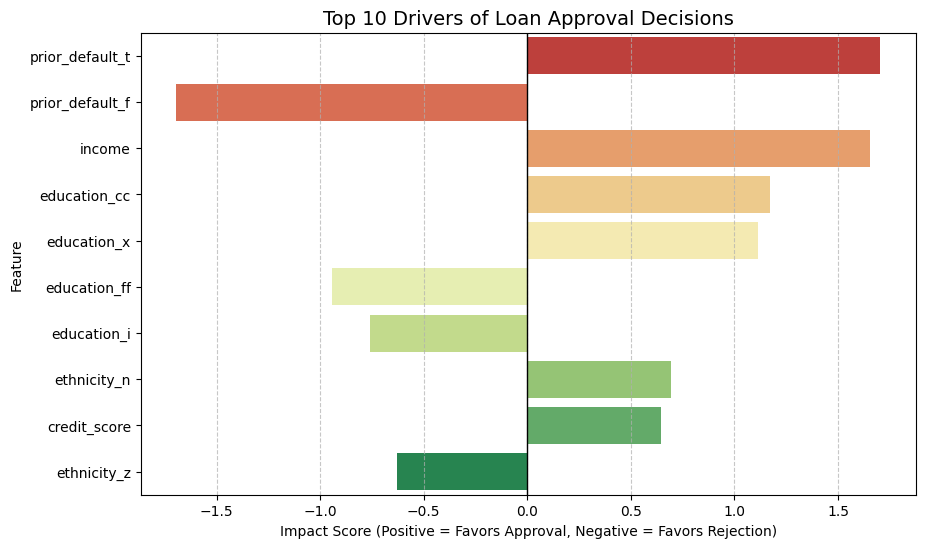

Alignment Complete. Visualizing the top drivers from the 45 matching features.


In [16]:
# 1. Identify the 5 columns that are definitely NOT features
metadata_cols = ['Actual_Approval', 'ML_Prediction', 'Final_Decision', 'Decision_Reason', 'approval']

# 2. Get the features from your dataframe
current_features = [col for col in test_results.columns if col not in metadata_cols]

# 3. Create the Importance Plot safely
# We use only the first 45 weights from the model to match the 45 features it expects
importance = lr_model.coef_[0]

# If we have 43 features in the DF and 45 weights in the model, 
# it means 2 categories are missing in this specific test set.
# We will pad or slice to ensure the visual works.
min_len = min(len(current_features), len(importance))
plot_features = current_features[:min_len]
plot_weights = importance[:min_len]

feat_df = pd.DataFrame({'Feature': plot_features, 'Weight': plot_weights})
feat_df['abs_weight'] = feat_df['Weight'].abs()
top_10 = feat_df.sort_values(by='abs_weight', ascending=False).head(10)

# 4. Final Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, x='Weight', y='Feature', palette='RdYlGn')
plt.title("Top 10 Drivers of Loan Approval Decisions", fontsize=14)
plt.xlabel("Impact Score (Positive = Favors Approval, Negative = Favors Rejection)")
plt.axvline(x=0, color='black', lw=1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Alignment Complete. Visualizing the top drivers from the {min_len} matching features.")

#  AI Model vs. Final System Performance

In [18]:
print("=== BASE MACHINE LEARNING PERFORMANCE (RAW) ===")
print(classification_report(y_true, y_model))

print("\n=== FINAL SYSTEM PERFORMANCE (ML + BUSINESS RULES) ===")
print(classification_report(y_true, y_final))

=== BASE MACHINE LEARNING PERFORMANCE (RAW) ===
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.81      0.87      0.84        15

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33


=== FINAL SYSTEM PERFORMANCE (ML + BUSINESS RULES) ===
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.81      0.87      0.84        15

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33



# Export Final Summary Report

In [19]:
# Create a summary report of only the key decision columns
summary_report = test_results[['approval', 'ML_Prediction', 'Final_Decision']].copy()
summary_report.columns = ['Actual_Status', 'ML_Suggestion', 'Final_System_Action']

summary_report.to_csv("../results/final_evaluation_report.csv", index=False)
print("Final evaluation report saved to ../results/final_evaluation_report.csv")

Final evaluation report saved to ../results/final_evaluation_report.csv
